In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from py2neo import Graph, authenticate, Relationship
from sklearn import preprocessing
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm, datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import Perceptron as PPN
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import plotly.offline as py
py.init_notebook_mode(connected=True)
import pandas_profiling
import random, os
from graphviz import Digraph
from IPython.display import Image
from pyquickhelper.helpgen import find_graphviz_dot
bin = os.path.dirname(find_graphviz_dot())
if bin not in os.environ["PATH"]:
    os.environ["PATH"] = os.environ["PATH"] + ";" + bin
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/dot.exe'
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin'

C:\Users\thaunayf\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\sphinx\util\compat.py:40: RemovedInSphinx17Warning:

sphinx.util.compat.Directive is deprecated and will be removed in Sphinx 1.7, please use docutils' instead.



In [3]:
data = pd.DataFrame.from_csv("PS_20174392719_1491204439457_log.csv", index_col=None)

In [4]:
# Fix typo errors
data = data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                            'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
data.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Basic informations

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest          object
oldBalanceDest    float64
newBalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
data.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
# nice package but limited for big size datasets
data_test = data[:100000]

In [10]:
pandas_profiling.ProfileReport(data_test)

Number of variables,11
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,8.4 MiB
Average record size in memory,88.0 B
Numeric,5
Categorical,2
Date,0
Text (Unique),1
Rejected,3
Distinct count,99470


In [5]:
types = pd.get_dummies(data["type"], prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False)

In [7]:
types.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [6]:
data = pd.concat([data, types], axis=1)

In [14]:
data.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


In [15]:
hourly = data.groupby(data.step).sum()         
daily = data.groupby(data.step//24).sum()

data_fraud = data[data.isFraud==1]
daily_fraud = data_fraud.groupby(data_fraud.step//24).sum()
hourly_fraud = data_fraud.groupby(data_fraud.step).sum()

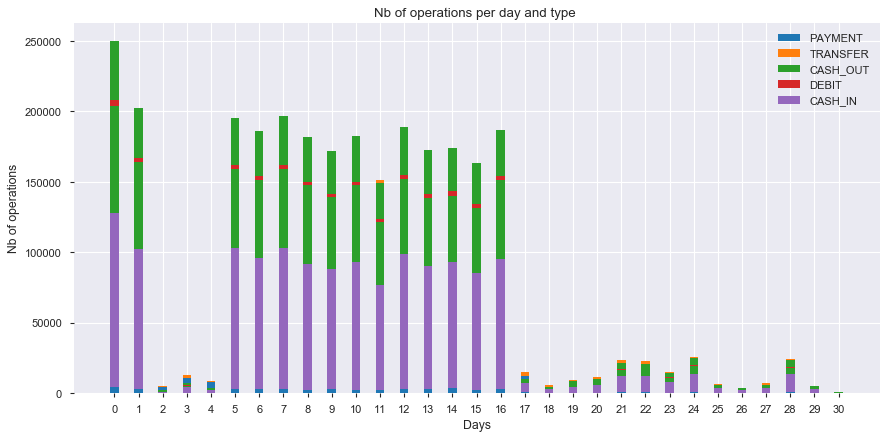

In [16]:
# DAILY + all data
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
N = len(daily)
paymentMeans = daily["PAYMENT"].tolist()
transferMeans = daily["TRANSFER"].tolist()
cash_outMeans = daily["CASH_OUT"].tolist()
debitMeans = daily["DEBIT"].tolist()
cash_inMeans = daily["CASH_IN"].tolist()

menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, paymentMeans, width)
p2 = plt.bar(ind, transferMeans, width, bottom=paymentMeans) 
p3 = plt.bar(ind, cash_outMeans, width, bottom=transferMeans)
p4 = plt.bar(ind, debitMeans, width, bottom=cash_outMeans) 
p5 = plt.bar(ind, cash_inMeans, width, bottom=debitMeans) 

plt.ylabel('Nb of operations')
plt.xlabel('Days')
plt.title('Nb of operations per day and type ')
plt.xticks(ind, (daily.index.tolist()))
plt.yticks()
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), (data.type.unique()))



plt.show()

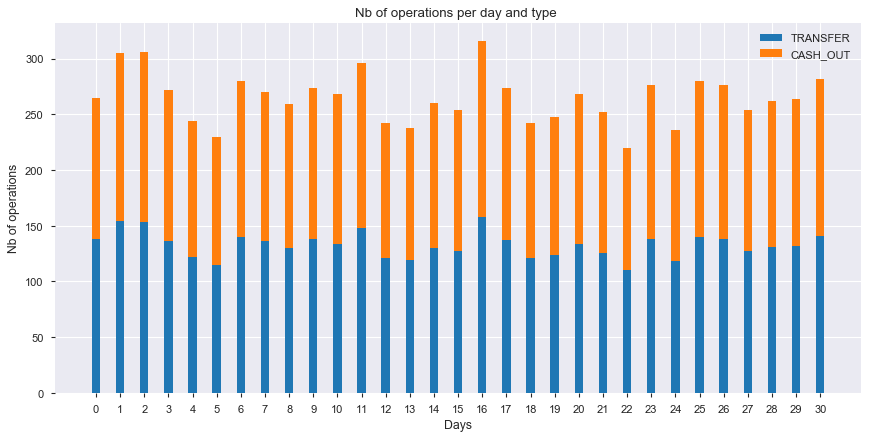

In [17]:
# DAILY + FRAUD
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
N = len(daily_fraud)
cash_outMeans = daily_fraud["CASH_OUT"].tolist()
transferMeans = daily_fraud["TRANSFER"].tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, cash_outMeans, width)
p2 = plt.bar(ind, transferMeans, width, bottom=cash_outMeans) 

plt.ylabel('Nb of operations')
plt.xlabel('Days')
plt.title('Nb of operations per day and type ')
plt.xticks(ind, (daily_fraud.index.tolist()))
plt.yticks()
plt.legend((p1[0], p2[0]), (data_fraud.type.unique()))



plt.show()

In [18]:
# Change style, for fun
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

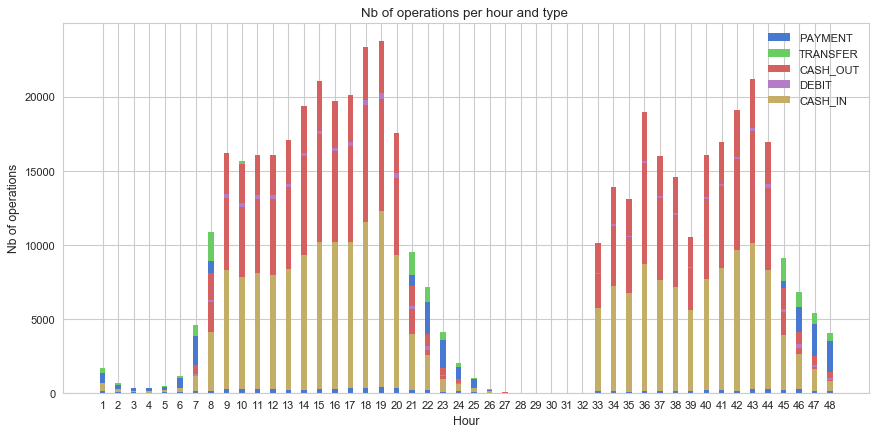

In [19]:
# HOURLY + all Data
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
N = len(hourly[:48])
paymentMeans = hourly[:48]["PAYMENT"].tolist()
transferMeans = hourly[:48]["TRANSFER"].tolist()
cash_outMeans = hourly[:48]["CASH_OUT"].tolist()
debitMeans = hourly[:48]["DEBIT"].tolist()
cash_inMeans = hourly[:48]["CASH_IN"].tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, paymentMeans, width)
p2 = plt.bar(ind, transferMeans, width, bottom=paymentMeans) 
p3 = plt.bar(ind, cash_outMeans, width, bottom=transferMeans)
p4 = plt.bar(ind, debitMeans, width, bottom=cash_outMeans) 
p5 = plt.bar(ind, cash_inMeans, width, bottom=debitMeans) 

plt.ylabel('Nb of operations')
plt.xlabel('Hour')
plt.title('Nb of operations per hour and type ')
plt.xticks(ind, (hourly.index.tolist()))
plt.yticks()
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), (data.type.unique()))



plt.show()

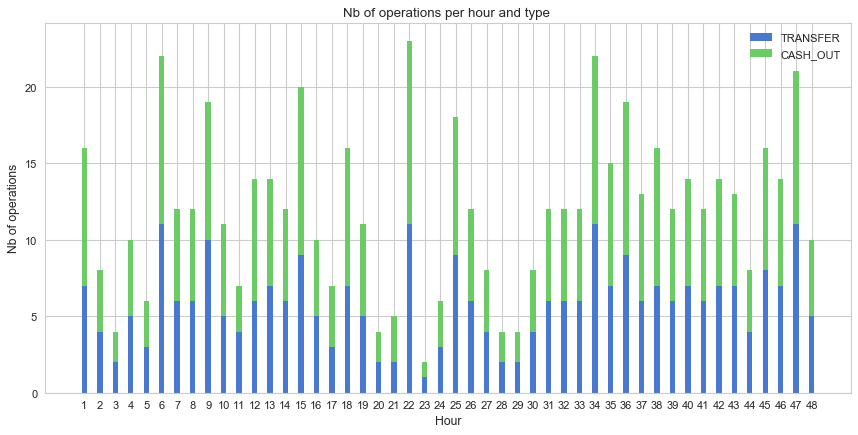

In [20]:
# HOURLY + FRAUD
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
N = len(hourly_fraud[:48])
transferMeans = hourly_fraud[:48]["TRANSFER"].tolist()
cash_outMeans = hourly_fraud[:48]["CASH_OUT"].tolist()

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, transferMeans, width) 
p2 = plt.bar(ind, cash_outMeans, width, bottom=transferMeans)

plt.ylabel('Nb of operations')
plt.xlabel('Hour')
plt.title('Nb of operations per hour and type ')
plt.xticks(ind, (hourly_fraud.index.tolist()))
plt.yticks()
plt.legend((p1[0], p2[0]), (data_fraud.type.unique()))



plt.show()

# Sample Data 

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

In [7]:
# First day 
df_day = data[data.step.isin(range(24))]

# Data Vizualisation

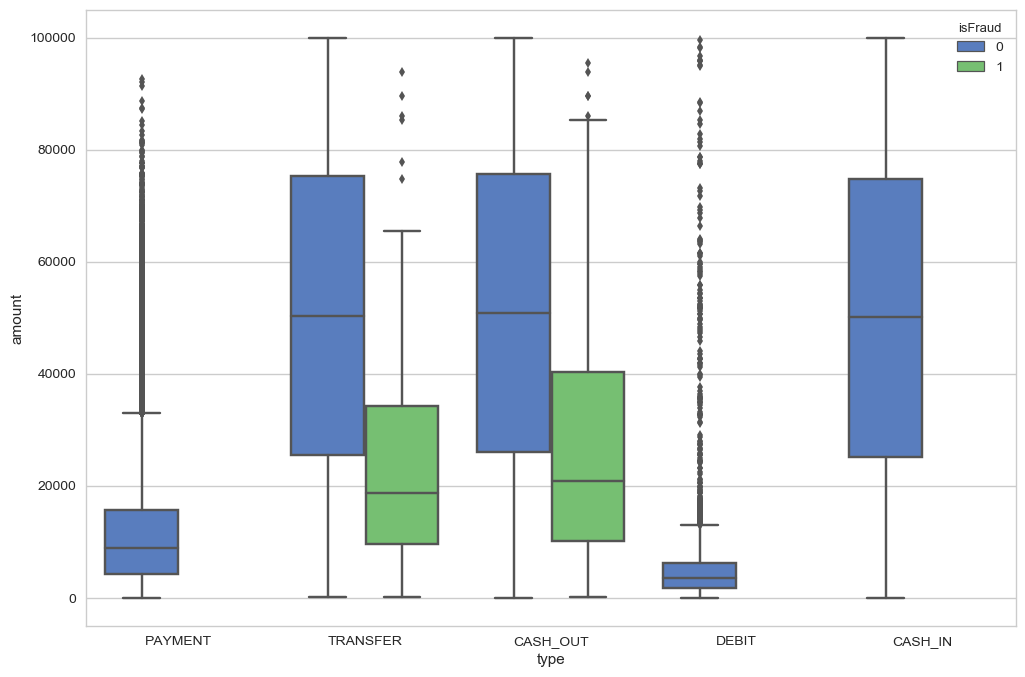

In [22]:
plt.figure(figsize=(12,8))
sns.boxplot(hue = 'isFraud', x = 'type', y = 'amount', data = df_day[df_day.amount < 1e5])

In [23]:
df_day[df_day.isFraud==1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

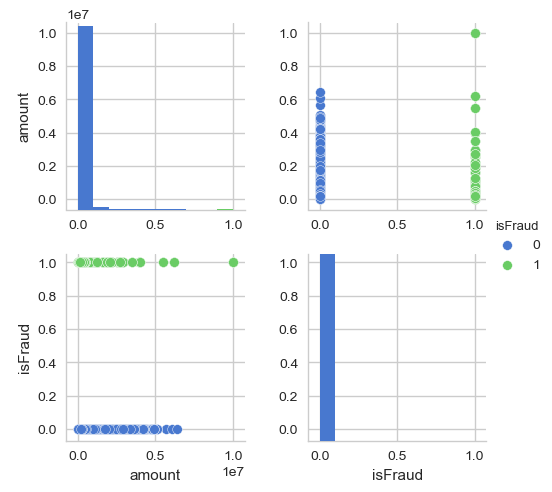

In [24]:
plt.figure(figsize=(20,5))
sns.pairplot(df_day[['amount','isFraud'][:1000]], hue='isFraud')

* Really few fraud -> efficiency for supervised learning
* Mostly small amounts -> interest of isFlaggedFraud variable ?

# Feature engineering

## Categorical variables : 
    - Not to much different values
    - equilibrium between occurences 
    - making groups based on frequencies or business logic ?

### Types

In [10]:
uniqueType = list(set(df_day.type.unique()))
print(uniqueType)

['CASH_OUT', 'DEBIT', 'CASH_IN', 'TRANSFER', 'PAYMENT']


In [11]:
pd.options.mode.chained_assignment = None 
df_day["typeAsNumeric"] = [uniqueType.index(v) for v in df_day["type"]]

### names

In [10]:
df_sample = df_day.sample(n=10000)
print(len(set(df_sample.nameOrig.unique())))
print(len(set(df_sample.nameDest.unique())))

# Because of anonymization, names are mostly differents.

10000
9349


In [31]:
df_sample.nameDest[:5]

304786     M486815143
174440    C1398683883
520330     C529351377
493243    C1470836835
236542     M737872023
Name: nameDest, dtype: object

In [12]:
# Owners are costumers or merchants
names = [name[0] for name in df_day["nameOrig"]]
costumersOrig = [int(n=="C") for n in names]
df_day["origIsCustomer"] = costumersOrig

names = [name[0] for name in df_day["nameDest"]]
costumersDest = [int(n=="C") for n in names]
df_day["destIsCustomer"] = costumersDest

### is Fraud
Fraudulent data are artificialy built, always in the same way : 
    - take the control of an account 
    - transfer to an other account
    - cash out
Actions : 
*              (Account A) -[TRANSFER] -> (Account B)
*              (Account B) - CASH_OUT

-> Use case for neo4j ?

### Because of anonymization, names are not usefull to follow money path. 

Just for playing : create link  

In [13]:
names = [name[:4] for name in df_day["nameOrig"]]
df_day["fakeNameOrig"] = names

names = [name[:4] for name in df_day["nameDest"]]
df_day["fakeNameDest"] = names

In [34]:
df_day.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,typeAsNumeric,origIsCustomer,destIsCustomer,fakeNameOrig,fakeNameDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,...,0,0,0,1,0,1,1,0,C123,M197
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,...,0,0,0,1,0,1,1,0,C166,M204
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,...,0,0,0,0,1,4,1,1,C130,C553
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,...,0,1,0,0,0,3,1,1,C840,C389
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,...,0,0,0,1,0,1,1,0,C204,M123


In [ ]:
df_day.to_csv("C:\\Users\\thaunayf\\Documents\Neo4j\\DC10_3\\import\\day1.csv")

In [ ]:
for i in range(24) :
    df_hour = df_day[day_df.step.isin(range(i,i+1))]
    df_hour.to_csv("C:\\Users\\thaunayf\\Documents\Neo4j\\DC10_3\\import\\hour"+str(i)+".csv", header=True)

In [36]:
graph = Graph(user="neo4j", password="admin")

In [38]:
a = graph.run('''
MATCH p= (a)-[action:RELTYPE{type:"TRANSFER"}]->(b)
RETURN b.Name
''').data()
print (a[:5])

[{'b.Name': 'C885'}, {'b.Name': 'C885'}, {'b.Name': 'C885'}, {'b.Name': 'C885'}, {'b.Name': 'C885'}]


In [39]:
b = graph.run('''
MATCH p= (a)-[action:RELTYPE{type:"CASH_OUT"}]->(b)
RETURN a.Name
''').data()
print (b[:5])

[{'a.Name': 'C664'}, {'a.Name': 'C153'}, {'a.Name': 'C122'}, {'a.Name': 'C107'}, {'a.Name': 'C654'}]


In [40]:
# 'C123' at row 1 
graph.run('''
MATCH p=shortestPath((a:Account { Name: 'C123' })-[r *..6]-(b: Account))
with length(p) as sp, b
return b.Name, sp
ORDER BY sp DESC LIMIT 2
''').data()

[{'b.Name': 'M541', 'sp': 2}, {'b.Name': 'C666', 'sp': 2}]

### Real case : Follow money


In [ ]:
# amounts = df.amount.unique().tolist()
# a = []
# for amount in amounts :
#     a.append(graph.run('''
# MATCH p= ()-[r1:RELTYPE{type:"TRANSFER"}]->(),  q= ()-[r2:RELTYPE{type:"CASH_OUT"}]->()
# WHERE r1.amount = $AMOUNT AND r2.amount = $AMOUNT AND r2.step >= r1.step
# RETURN p, q, r1.dataLine AS row1, r2.dataLine as row2
# ''',{'AMOUNT': amount}).data())

SQL request, too long with graph Database => do it with DataFrame

In [14]:
df_transfer = df_day[df_day.type=="TRANSFER"]
df_cash_out = df_day[df_day.type=="CASH_OUT"]
amounts = df_day[df_day.type.isin(["TRANSFER", "CASH_OUT"])].amount.unique().tolist()

followMoney = []

for amount in amounts :
    df_transfer_amount = df_transfer[df_transfer.amount==amount]
    df_cash_out_amount = df_cash_out[df_cash_out.amount==amount]

    for i, row in df_transfer_amount.iterrows() :
        for j, row2 in df_cash_out_amount.iterrows() :
            if (row["step"] == row2["step"]) :
                followMoney.append(i)
                followMoney.append(j)

df_day["followMoney"] = np.zeros(len(df_day))
for b in followMoney :
    df_day.at[b, 'followMoney'] = 1


### Amounts as categories

In [15]:
amounts = df_day.amount.tolist()
ave_amounts = [int(np.log10(amount)*10) for amount in amounts]
df_day["categorized_amount"] = ave_amounts

### Additional feature : errors in data

In [16]:
df_nonFraud = df_day.loc[(df_day.isFraud == 0)]
df_fraud = df_day.loc[(df_day.isFraud == 1)]

In [18]:
errorInOrig, errorInDest, errorInTransfer = 0, 0, 0
for i,row in df_nonFraud.iterrows():
   
    if (abs(row["amount"] - (row.oldBalanceOrig - row.newBalanceOrig)) > 1):
        errorInOrig +=1
    if(abs(row["amount"] - (row.newBalanceDest - row.oldBalanceDest)) > 1  & row["destIsCustomer"] == 1)  :
        errorInDest +=1
    if(abs((row.oldBalanceOrig - row.newBalanceOrig) - (row.newBalanceDest - row.oldBalanceDest)) > 1 & row["destIsCustomer"] == 1) :
        errorInTransfer +=1
        
print  ("Error in percents : \n ")
print (" - If genuine : \n")
print ("     Origin - Amount: {0:.1f}, Destination - Amount: {1:.1f}, Origin - Destination  {2:.1f}  \n".format((float(errorInOrig)/len(df_nonFraud)),(float(errorInDest)/len(df_nonFraud)), (float(errorInTransfer)/len(df_nonFraud))))

errorInOrig, errorInDest, errorInTransfer = 0, 0, 0
for i,row in df_fraud.iterrows():
   
    if (abs(row["amount"] - (row.oldBalanceOrig - row.newBalanceOrig)) > 1):
        errorInOrig +=1
    if(abs(row["amount"] - (row.newBalanceDest - row.oldBalanceDest)) > 1  & row["destIsCustomer"] == 1)  :
        errorInDest +=1
    if(abs((row.oldBalanceOrig - row.newBalanceOrig) - (row.newBalanceDest - row.oldBalanceDest)) > 1 & row["destIsCustomer"] == 1) :
        errorInTransfer +=1

print (" - If fraud : \n")
print ("     Origin - Amount: {0:.1f}, Destination - Amount: {1:.1f}, Origin - Destination  {2:.1f}  \n".format((float(errorInOrig)/len(df_fraud)),(float(errorInDest)/len(df_fraud)), (float(errorInTransfer)/len(df_fraud))))


Error in percents : 
 
 - If genuine : 

     Origin - Amount: 0.8, Destination - Amount: 0.4, Origin - Destination  0.5  

 - If fraud : 

     Origin - Amount: 0.1, Destination - Amount: 0.7, Origin - Destination  0.8  



In [ ]:
df_day["errorInOrig"], df_day["errorInDest"], df_day["errorInDest"] = \
                        np.zeros(len(df_day)), np.zeros(len(df_day)), np.zeros(len(df_day))

for i,row in df_nonFraud.iterrows():

    df_day["errorInOrig"][i]=(abs(row["amount"] - (row.oldBalanceOrig - row.newBalanceOrig)) > 1)
    df_day["errorInDest"][i]=(abs(row["amount"] - (row.newBalanceDest - row.oldBalanceDest)) > 1  & row["destIsCustomer"] == 1)
    df_day["errorInDest"][i]=(abs((row.oldBalanceOrig - row.newBalanceOrig) - (row.newBalanceDest - row.oldBalanceDest)) > 1 
                            & row["destIsCustomer"] == 1)
for i,row in df_fraud.iterrows():

    df_day["errorInOrig"][i]=(abs(row["amount"] - (row.oldBalanceOrig - row.newBalanceOrig)) > 1)
    df_day["errorInDest"][i]=(abs(row["amount"] - (row.newBalanceDest - row.oldBalanceDest)) > 1  & row["destIsCustomer"] == 1)
    df_day["errorInDest"][i]=(abs((row.oldBalanceOrig - row.newBalanceOrig) - (row.newBalanceDest - row.oldBalanceDest)) > 1 
                            & row["destIsCustomer"] == 1)

## Save DataFrame 

In [ ]:
df_day.to_csv("df_day.csv")

In [3]:
df_day = pd.DataFrame.from_csv("df_day.csv", index_col=None)

In [3]:
df_day.head()

,Unnamed: 0,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,...,isFlaggedFraud,typeAsNumeric,origIsCustomer,destIsCustomer,fakeNameOrig,fakeNameDest,followMoney,categorized_amount,errorInOrig,errorInDest
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,...,0,2,1,0,C123,M197,0.0,39,0.0,0.0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,...,0,2,1,0,C166,M204,0.0,32,0.0,0.0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,...,0,1,1,1,C130,C553,1.0,22,0.0,1.0
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,...,0,0,1,1,C840,C389,1.0,22,0.0,1.0
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,...,0,2,1,0,C204,M123,0.0,40,0.0,0.0


In [18]:
df_day.columns

Index(['Unnamed: 0', 'step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud', 'typeAsNumeric', 'origIsCustomer',
       'destIsCustomer', 'fakeNameOrig', 'fakeNameDest', 'followMoney',
       'categorized_amount', 'errorInOrig', 'errorInDest'],
      dtype='object')

# Supervised learning

In [6]:
# First, separate data in train / valid and test sets, ovoiding overfitting when features selection use other sets than train  
# train : 0.6, valid : 0.2, test : 0.2

In [7]:
msk = np.random.rand(len(df_day)) < 0.8
train_valid = df_day[msk]
test = df_day[~msk]
msk = np.random.rand(len(train_valid)) < 0.75
train = train_valid[msk]
valid = train_valid[~msk]
print (len(train)*1.0/len(df_day))
print (len(valid)*1.0/len(df_day))
print (len(test)*1.0/len(df_day))

0.6011638434502722
0.19942420745343137
0.1994119490962964


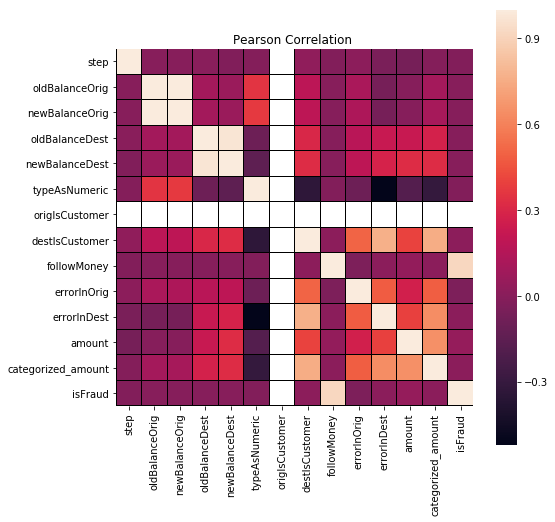

In [7]:

# Set up the matplotlib figure
g, ax2 = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation ')
# Draw the heatmap using seaborn
sns.heatmap(train[[u'step', u'oldBalanceOrig', u'newBalanceOrig', u'oldBalanceDest', u'newBalanceDest', 
        u'typeAsNumeric', u'origIsCustomer', u'destIsCustomer', u'followMoney', u'errorInOrig', u'errorInDest', u'amount',
        u'categorized_amount', u'isFraud',]].astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, linecolor='black')


* Strong correlation between old and new Balance : probably because of null or non updated values 
* We already see that followMoney will be "the" important feature
* origIsCustomer -> always the case

In [8]:
X = np.array(train[[u'step', u'amount', u'newBalanceOrig', u'newBalanceDest',
        u'typeAsNumeric', u'destIsCustomer', u'followMoney', u'errorInOrig', u'errorInDest',
        u'categorized_amount']])
X_scaled = preprocessing.scale(X)

In [9]:
y = np.array(train[["isFraud"]])
y2 = np.array([v[0] for v in y])

### feature selection

Feature ranking:
1. followMoney (0.644246)
2. newBalanceOrig (0.151330)
3. errorInOrig (0.095791)
4. amount (0.034676)
5. categorized_amount (0.020987)
6. newBalanceDest (0.019976)
7. typeAsNumeric (0.014134)
8. step (0.014087)
9. errorInDest (0.003953)
10. destIsCustomer (0.000819)


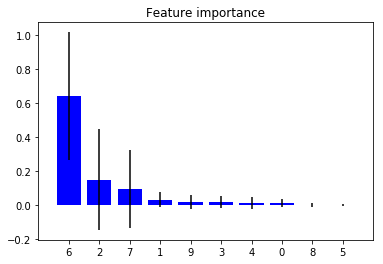

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y2, random_state=0)
#RF : RandomForestClassifier
forest = RF(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
forest_fit = forest.fit(X_train, y_train)
forest_prediction = forest_fit.predict(X_test)

# renvoie un array avec les importances relatives des 10 premieres caracteristiques
importances = forest_fit.feature_importances_[:10]

# numpy.std : Returns the standard deviation, a measure of the spread of a distribution
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# Renvoie un tableau des indices dans l'ordre où ils seraient après un tri
indices = np.argsort(importances)[::-1]

columns = [u'step', u'amount', u'newBalanceOrig', u'newBalanceDest',
        u'typeAsNumeric', u'destIsCustomer', u'followMoney', u'errorInOrig', u'errorInDest',
        u'categorized_amount']
#Print the feature ranking
print("Feature ranking:")
features = [x for y, x in sorted(zip(importances,columns), reverse=True)]

for f in range(10):
    print("%d. %s (%f)" % (f+1, features[f], importances[indices[f]]))
    
#plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices], yerr=std[indices], color="b", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1,10])
plt.show()

### Remove note usefull features

In [10]:
X = np.array(train[["followMoney","newBalanceOrig","errorInOrig","amount"]])
X_scaled = preprocessing.scale(X)

- Accuracy = (TP + TN) / Total
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

Most interesting indicator should be the recall score to capture the most fraudulent transactions. 

In [11]:
def recall_score(y_true, y_pred, labels=None, pos_label=1, average="binary", sample_weight=None):
    return recall_score(y_true, y_pred)

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred)

def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(n_splits=3)
    y_pred = y.copy()
  
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [12]:
X_sample = X_scaled
y_sample = y2

## Manage imbalanced classes

In [13]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

print(sorted(Counter(y_sample).items()))

# 1- oversampling (generate noise)
# 2- undersampling using cleaning method (eliminate this noise)

smote_enn = SMOTEENN(random_state=0)
X_resampled_enn, y_resampled_enn = smote_enn.fit_sample(X_sample, y_sample)
print(sorted(Counter(y_resampled_enn).items()))

smote_tomek = SMOTETomek(random_state=0)
X_resampled_tomek, y_resampled_tomek = smote_tomek.fit_sample(X_sample, y_sample)
print(sorted(Counter(y_resampled_tomek).items()))

[(0, 343115), (1, 173)]
[(0, 297492), (1, 322206)]
[(0, 331336), (1, 331336)]


In [33]:
from collections import Counter
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler

def plot_pie(ys):
    """
    Plot pies from classes population
    :param ys: list of classes
    :return: None
    """
    target_stats=[]
    labels=[]
    sizes=[]
    explode=[]
    for i,y in enumerate(ys) :
        target_stats.append(Counter(y))
        labels.append(list(target_stats[i].keys()))
        sizes.append(list(target_stats[i].values()))
        explode.append(tuple([0.1] * len(target_stats[i])))

    plt.close('all')



    # Two subplots, the axes array is 1-d
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(13,4))

    ax1.pie(sizes[0], explode=explode[0], labels=labels[0], shadow=True,
           autopct='%1.2f%%')
    ax1.set_title('y_sample')
    ax2.pie(sizes[1], explode=explode[1], labels=labels[1], shadow=True,
           autopct='%1.2f%%')
    ax2.set_title('y_resampled_enn')
    ax3.pie(sizes[2], explode=explode[2], labels=labels[2], shadow=True,
           autopct='%1.2f%%')
    ax3.set_title('y_resampled_tomek')
    
    plt.show()


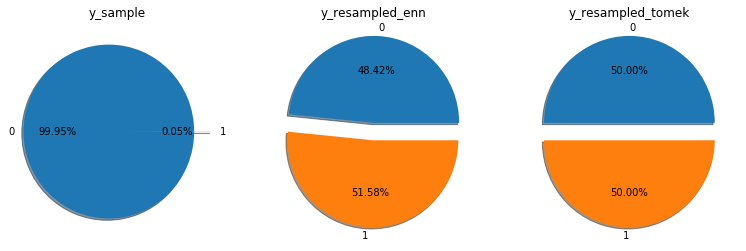

In [34]:
plot_pie([y_sample, y_resampled_enn, y_resampled_tomek])

In [35]:
print ("y_sample: {0:0.2f} values, with {1:0.2f} fraud \n".format(len(y_sample), y_sample.sum()))
print ("y_resampled_enn: {0:0.2f} values, with {1:0.2f} fraud \n".format(len(y_resampled_enn), y_resampled_enn.sum()))
print ("y_resampled_tomek: {0:0.2f} values, with {1:0.2f} fraud \n".format(len(y_resampled_tomek), y_resampled_tomek.sum()))

y_sample: 342892.00 values, with 160.00 fraud 

y_resampled_enn: 608684.00 values, with 313941.00 fraud 

y_resampled_tomek: 657430.00 values, with 328715.00 fraud 



In [18]:
from sklearn.metrics import recall_score
import time
# Test different models
models = ["Logistic Regression:", "Gradient Boosting Classifier", "Support vector machines:",
          "Random forest:","K-nearest-neighbors:"]
algos = [LR, GBC, SVC(kernel='linear',class_weight='balanced',probability=True), RF, KNN]

In [11]:
# y_resampled_enn
for i, row in enumerate(models):
    from sklearn.metrics import f1_score
    print (models[i])
    start_time = time.time()
    y_pred = run_cv(X_resampled_enn,y_resampled_enn,algos[i])
    f1_score = f1_score(y_resampled_enn, y_pred, average=None)
    print ("Accuracy: {0:0.2f} and recall : {1:0.2f}".format(f1_score[0], f1_score[1]))
    print("--- %s seconds ---\n" % (time.time() - start_time))

Logistic Regression:
Accuracy: 0.97 and recall : 0.97
--- 3.8339998722076416 seconds ---

Gradient Boosting Classifier
Accuracy: 1.00 and recall : 1.00
--- 45.42199993133545 seconds ---

Support vector machines:
Accuracy: 0.98 and recall : 0.98
--- 115.66400003433228 seconds ---

Random forest:
Accuracy: 1.00 and recall : 1.00
--- 1.688999891281128 seconds ---

K-nearest-neighbors:
Accuracy: 1.00 and recall : 1.00
--- 27.052000045776367 seconds ---



In [12]:
# y_resampled_tomek
for i, row in enumerate(models):
    from sklearn.metrics import f1_score
    print (models[i])
    start_time = time.time()
    y_pred = run_cv(X_resampled_tomek,y_resampled_tomek,algos[i])
    f1_score = f1_score(y_resampled_tomek, y_pred, average=None)
    print ("Accuracy: {0:0.2f} and recall : {1:0.2f}".format(f1_score[0], f1_score[1]))
    print("--- %s seconds ---\n" % (time.time() - start_time))

Logistic Regression:
Accuracy: 0.97 and recall : 0.97
--- 0.939000129699707 seconds ---

Gradient Boosting Classifier
Accuracy: 1.00 and recall : 1.00
--- 29.203999996185303 seconds ---

Support vector machines:
Accuracy: 0.98 and recall : 0.98
--- 235.2149999141693 seconds ---

Random forest:
Accuracy: 1.00 and recall : 1.00
--- 1.8050000667572021 seconds ---

K-nearest-neighbors:
Accuracy: 1.00 and recall : 1.00
--- 27.79200005531311 seconds ---



In [14]:
X_valid = np.array(valid[["followMoney","newBalanceOrig","errorInOrig","amount"]])
X_valid_scaled = preprocessing.scale(X_valid)
y_valid = np.array(valid[["isFraud"]])
y_valid2 = np.array([v[0] for v in y_valid])

In [15]:
def run_cv2(X_resampled,y_resampled, X_valid_scaled, y_valid,clf_class,**kwargs):
    clf = clf_class(**kwargs)
    clf.fit( X_resampled,y_resampled)
    y_pred = clf.predict(X_valid_scaled)
    return y_pred

In [19]:
from sklearn.metrics import f1_score
start_time = time.time()
clf = SVC(kernel='linear')
clf.fit( X_resampled_enn,y_resampled_enn)
y_pred = clf.predict(X_valid_scaled)
f1_score = f1_score(y_valid2, y_pred, average=None)
print ("Accuracy: {0:0.2f} and recall : {1:0.2f}".format(f1_score[0], f1_score[1]))
print("--- %s seconds ---\n" % (time.time() - start_time))

Accuracy: 1.00 and recall : 0.89
--- 294.6340003013611 seconds ---



In [61]:
# Penalized-SVM


from sklearn.metrics import f1_score
start_time = time.time()
clf = SVC(kernel='linear',class_weight='balanced',probability=True)
clf.fit( X_resampled_enn,y_resampled_enn)
y_pred = clf.predict(X_valid_scaled)
f1_score = f1_score(y_valid2, y_pred, average=None)
print ("Accuracy: {0:0.2f} and recall : {1:0.2f}".format(f1_score[0], f1_score[1]))
print("--- %s seconds ---\n" % (time.time() - start_time))

Accuracy: 1.00 and recall : 0.95
--- 5731.792000055313 seconds ---



In [87]:
df2 = pd.DataFrame(data=X_resampled_en, columns = [u'amount', u'newBalanceOrig', u'newBalanceDest',
        u'typeAsNumeric', u'followMoney', u'errorInOrig', u'categorized_amount'] )
df3 = pd.DataFrame(data=y_resampled_en, columns = ['isFraud'] )
df4 = pd.concat([df2,df3], axis=1)
df4.head()

,amount,newBalanceOrig,newBalanceDest,typeAsNumeric,followMoney,errorInOrig,categorized_amount,isFraud
0,-0.566632,-0.249429,-0.45954,0.469710,-0.021547,-1.782048,-0.938915,0
1,-0.596596,-0.296158,-0.45954,0.469710,-0.021547,-1.782048,-1.817872,0
2,-0.602921,-0.302586,-0.45954,-0.364072,46.409742,-1.782048,-3.073526,1
3,-0.602921,-0.302586,-0.45954,-1.197855,46.409742,-1.782048,-3.073526,1
4,-0.559762,-0.292675,-0.45954,0.469710,-0.021547,-1.782048,-0.813349,0


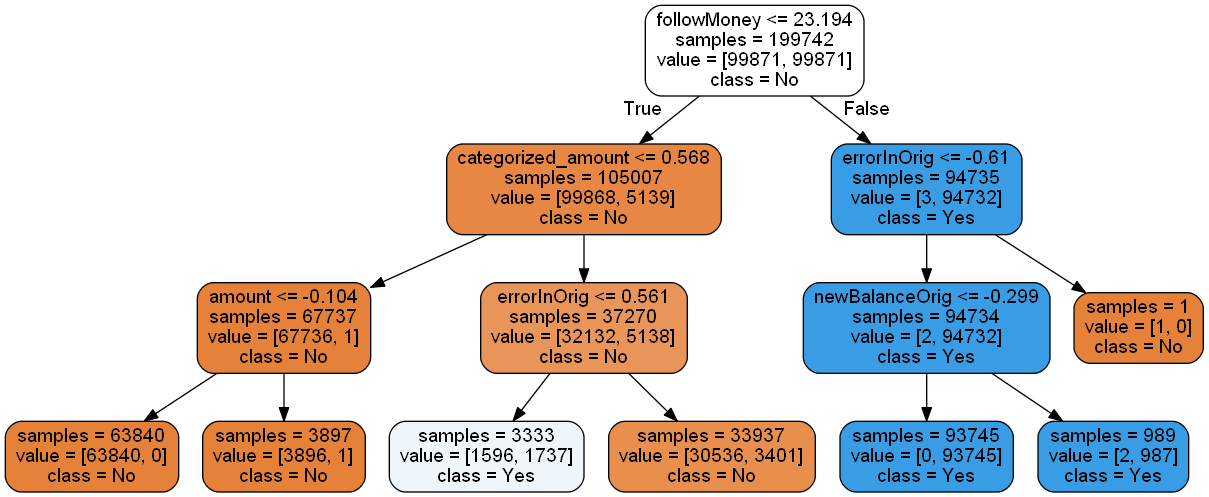

In [89]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(df4.drop(['isFraud'],axis=1), df4["isFraud"])

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = df4.drop(['isFraud'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook

# check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)     
        

In [15]:
results = df_day.groupby(df_day["isFraud"]).mean()
results = results.reset_index()
results.head()


,isFraud,Unnamed: 0,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFlaggedFraud,typeAsNumeric,origIsCustomer,destIsCustomer,followMoney,categorized_amount,errorInOrig,errorInDest
0,0,285556.735126,14.776221,160363.136387,892849.988144,912873.900179,973197.235492,1.139461e+06,0.0,1.437096,1.0,0.661952,0.000033,46.475726,0.760842,0.533285
1,1,204242.664151,11.754717,787146.315094,785388.389434,20879.668075,458684.990113,9.612051e+05,0.0,0.479245,1.0,1.000000,0.928302,50.290566,0.064151,0.769811
